[[-0.77320508  0.          0.        ]
 [-0.47320508  0.          0.        ]
 [-0.17320508  0.          0.        ]
 [ 0.08660254  0.15        0.        ]
 [ 0.08660254 -0.15        0.        ]
 [ 0.23660254  0.40980762  0.        ]
 [ 0.23660254 -0.40980762  0.        ]
 [ 0.38660254  0.66961524  0.        ]
 [ 0.38660254 -0.66961524  0.        ]]


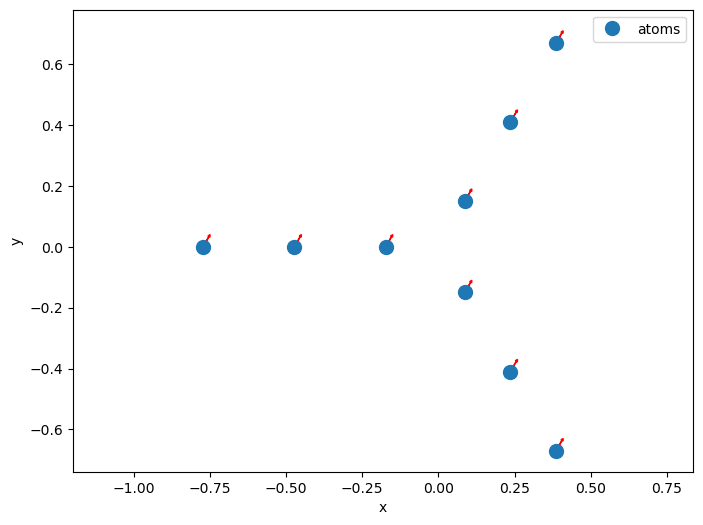

In [1]:
N = 3 + 3 * 2

from tqdm import tqdm
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os

fixed_lam = 1
fixed_gamma = 1

fixed_dist_in  = 0.3  * fixed_lam
fixed_dist_ext  = 1 * fixed_dist_in
fixed_phi  = 0

x_0    = 0.2
x_max  = 1.1

t_max  = 40

phi_0    = 0
phi_max  = 2 * np.pi / 3

phi_size = 20
x_size   = 50
t_size   = 5
dists  = np.linspace(x_0, x_max, x_size) * fixed_lam
times  = np.linspace(0, t_max, t_size) * fixed_gamma

def dipole_vector(phi = fixed_phi):
    dipole = np.array([np.cos(phi), np.sin(phi), 0])
    return dipole
def initial_DIPOLES(N):
    init_pop = np.zeros(N)
#    init_pop[N//3:] = np.tile([-np.pi/3, np.pi/3], (N - N//3) // 2)
    init_dipoles = [dipole_vector(np.pi/3) for _ in init_pop] 
    return init_dipoles

def atom_positions(d_in = fixed_dist_in, d_ext = fixed_dist_ext, N = N):
    Pos = np.zeros((N, 3))
    cos = np.cos(2 * np.pi / 6)
    sin = np.sin(2 * np.pi / 6)
    x = d_in / (2 * np.cos(np.pi / 6))
    Pos[0] = (- x, 0, 0)
    Pos[1] = (+ x * cos, + x * sin, 0)
    Pos[2] = (+ x * cos, - x * sin, 0)
    for i in range((N-1) // 3):
        Pos[3 * (i+1)] = Pos[0]     + (- (i+1) * d_ext, 0, 0)
        Pos[3 * (i+1) + 1] = Pos[1] + (+ (i+1) * d_ext * cos, + (i+1) * d_ext * sin, 0)
        Pos[3 * (i+1) + 2] = Pos[2] + (+ (i+1) * d_ext * cos, - (i+1) * d_ext * sin, 0)
    Pos_sorted = Pos[Pos[:, 0].argsort()]
    return Pos_sorted
positions = atom_positions(fixed_dist_in, fixed_dist_in)
print(positions)
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x
plt.figure(figsize=(8, 6))
plt.plot(positions[:, 0], positions[:, 1], 'o', markersize=10, label='atoms')
#plt.arrow(0, 0, dipole_vector()[0] * scale, dipole_vector()[1] * scale, 
#          head_width=0.5*scale, head_length=0.5*scale, fc='r', ec='r', label='dipole vec')
initital_dipoles = initial_DIPOLES(N)
# Plot dipole vectors
for i, position in enumerate(positions):
    plt.arrow(position[0], position[1], initital_dipoles[i][0] * scale, initital_dipoles[i][1] * scale, 
              head_width=0.2*scale, head_length=0.2*scale, fc='r', ec='r')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')
plt.show()
def Green_tensor(r_a, r_b, k_a):
    r_ab = r_b - r_a
    abs_r_ab = np.linalg.norm(r_ab)
    kappa = k_a * abs_r_ab
    Greenstensor = (np.exp(1j * kappa) / (4 * np.pi * kappa ** 2 * abs_r_ab)
                    * ((kappa ** 2 + 1j * kappa - 1) * np.eye(3)
                       + (- kappa ** 2 - 3 * 1j * kappa + 3)
                       * np.outer(r_ab, r_ab) / (abs_r_ab ** 2)))
    return Greenstensor
def Gamma_coefficients(r_a, r_b,
                       d_a = dipole_vector(), 
                       d_b = dipole_vector(),
                       lam = fixed_lam,
                       gamma = fixed_gamma) -> float:

    if np.linalg.norm(r_b - r_a) < 1e-5:
        return gamma
    k_a = 2 * np.pi / lam
    result = (6 * np.pi * gamma / k_a  # also / d^2 but it has length 1
              * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
    return np.imag(result)
def V_coefficients(r_a, r_b,
                   d_a = dipole_vector(), 
                   d_b = dipole_vector(),
                   lam = fixed_lam,
                   gamma = fixed_gamma) -> float:
    
    if np.linalg.norm(r_b - r_a) < 1e-5:
        return 0
    k_a = 2 * np.pi / lam
    result = (-3 * np.pi * gamma / k_a # also / d^2 but it has length 1
              * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
    return np.real(result)

def H_eff(distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, dipoles = [dipole_vector() for _ in range(N)], lam=fixed_lam, gamma=fixed_gamma, N=N):
    positions = atom_positions(distance_in, distance_ext, N)
    H_eff_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            r_a = positions[a]
            r_b = positions[b]
            V_ab = V_coefficients(r_a, r_b, dipoles[a], dipoles[b], lam, gamma)
            Gamma_ab = Gamma_coefficients(r_a, r_b, dipoles[a], dipoles[b], lam, gamma)
            matrix_element = V_ab - 1j * 0.5 * Gamma_ab
            H_eff_matrix[a, b] = matrix_element
    return Qobj(H_eff_matrix)

In [2]:
# Solve the system
H = H_eff(dipoles=initital_dipoles)
################ initiate Wave-packet
psi0 = basis(N,0)
result = mesolve(H, psi0, times, c_ops=[], e_ops=[], args={}, options=None, progress_bar=None, _safe_mode=True)
for i in range(len(result.states)):
    print(f"Time {times[i]}: Norm of the state is {result.states[i].norm()}")
probabilities = np.zeros((N, len(times)))
for t_idx, state in enumerate(result.states):
    for i in range(N):
        probability = np.abs(state.full()[i])**2
        probabilities[i, t_idx] = probability

Time 0.0: Norm of the state is 1.0
Time 10.0: Norm of the state is 0.9999999999999999
Time 20.0: Norm of the state is 1.0000000000000002
Time 30.0: Norm of the state is 1.0
Time 40.0: Norm of the state is 1.0


C:\Users\leopo\anaconda3\Lib\site-packages\qutip\solver\solver_base.py:453: FutureWarning: "progress_bar" is now included in options:
 Use `options={"progress_bar": False / True / "tqdm" / "enhanced"}`
  warnings.warn(
C:\Users\leopo\anaconda3\Lib\site-packages\qutip\solver\solver_base.py:461: FutureWarning: "_safe_mode" is no longer supported.
  warnings.warn(
C:\Users\leopo\AppData\Local\Temp\ipykernel_8448\664554207.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  probabilities[i, t_idx] = probability


[1. 1. 1. 1. 1.]
[[1.00000000e+00 1.35178603e-01 8.15476703e-02 7.10947983e-02
  7.04369991e-02]
 [0.00000000e+00 3.17281838e-01 1.94337440e-01 1.73359441e-01
  1.70354735e-01]
 [0.00000000e+00 2.46879964e-01 2.39841193e-01 2.40804125e-01
  2.43706578e-01]
 [0.00000000e+00 3.72008571e-02 4.50840577e-03 1.49869727e-03
  1.69370334e-03]
 [0.00000000e+00 1.82908536e-01 2.69114566e-01 2.70510223e-01
  2.67460337e-01]
 [0.00000000e+00 3.27575958e-03 7.01021814e-04 1.57471472e-03
  1.69365188e-03]
 [0.00000000e+00 3.36230902e-02 1.49009727e-01 1.70101918e-01
  1.72944010e-01]
 [0.00000000e+00 3.19208960e-02 6.76723839e-04 5.77126608e-04
  6.49387840e-04]
 [0.00000000e+00 1.17304566e-02 6.02632524e-02 7.04789561e-02
  7.10605973e-02]]


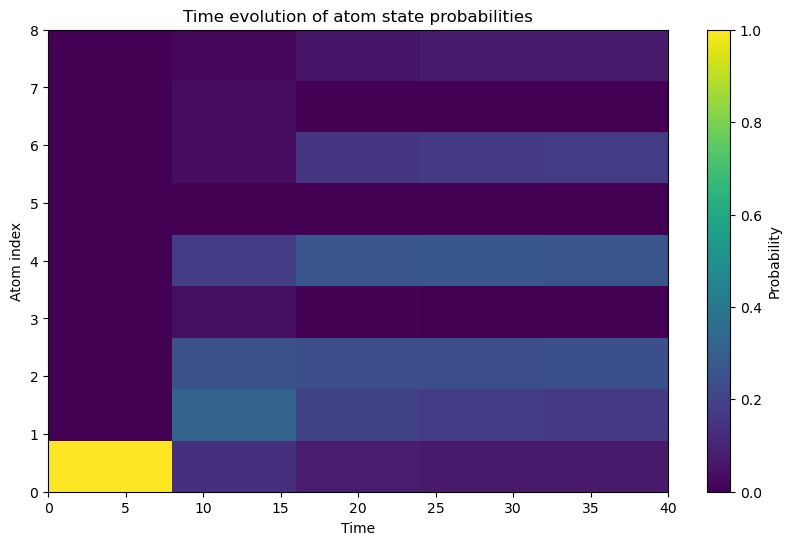

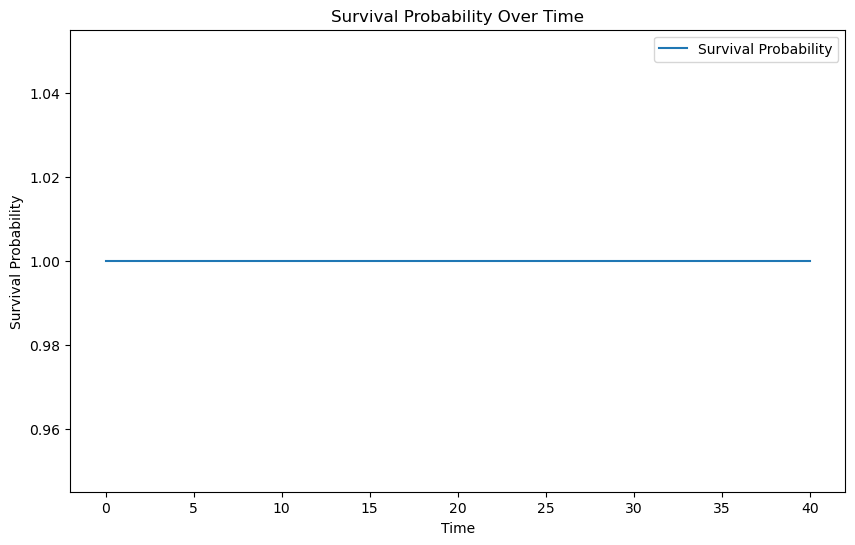

In [3]:
# Calculate survival probability
P_sur = np.sum(probabilities, axis=0)
print(P_sur)
print(probabilities)
# Create a heatmap for state probabilities
plt.figure(figsize=(10, 6))
plt.imshow(probabilities, aspect='auto', origin='lower', cmap='viridis', extent=[0, t_max, 0, N-1])
plt.colorbar(label='Probability')
plt.xlabel('Time')
plt.ylabel('Atom index')
plt.title('Time evolution of atom state probabilities')
plt.show()

# Plot survival probability
plt.figure(figsize=(10, 6))
plt.plot(times, P_sur, label='Survival Probability')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Probability Over Time')
plt.legend()
plt.show()